In [1]:
%matplotlib inline
import matplotlib


In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import h5py

In [3]:
#Change the path to hdf5 file
hdf5_path = 'C:/Users/nitis/OneDrive/Documents/Deep Learning/Project/data.hdf5'

In [4]:
def read_from_hdf5(hdf5_path):
    print("Reading data from hdf5 file:",hdf5_path)
    data = []
    f = h5py.File(hdf5_path,'r')
    key = (list(f.keys())[0])
    data = list(f[key])
    print("Rows of data read:",len(data))
    return data


In [5]:
images = read_from_hdf5(hdf5_path)

Reading data from hdf5 file: C:/Users/nitis/OneDrive/Documents/Deep Learning/Project/data.hdf5
Rows of data read: 214


In [6]:
data = np.array(images)
print(data.shape)

n = data.shape[0]
m = data.shape[1]

imageset = np.empty((7704,64,64,3), dtype='float32')


(214, 36, 64, 64, 3)


In [7]:
FlattenImageData= []
FlattenImageData = FlattenImageData + [data[x][y] for x in range(n) for  y in range(m)]
imageset = np.array(FlattenImageData)
print(imageset.shape)

(7704, 64, 64, 3)


(64, 64, 3)


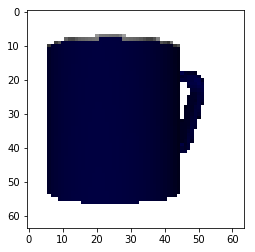

In [8]:
#this part is to visulize image
tmp = imageset[3569]

print(tmp.shape)
plt.imshow(tmp/255)
plt.show()


In [9]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 44 folders would be used for testing



data_ = np.zeros(imageset.shape)
labels_ = np.zeros(imageset.shape)
pose = np.zeros((7704,8,8,36))


for cnt in range(n):
    for itr in range(m):
        data_[(cnt*36) + itr] = imageset[cnt*36]
        pose_tmp = np.zeros(36)
        pose_tmp[itr] = 1
        pose[(cnt*36) + itr] = np.broadcast_to(pose_tmp,(8,8,36))
        labels_[(cnt*36) + itr] =  imageset[(cnt*36) + itr]
        #print( (cnt*36) + itr)

data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
#This code will generate labels for the dataset
#perm = np.random.permutation(data_.shape[0])

# data_ = data_[perm]
# labels_ = labels_[perm]
# pose = pose[perm]

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image

data_train = np.array(data_[:6120])
data_test = np.array(data_[6120:])

train_labels = np.array(labels_[:6120])
test_labels = np.array(labels_[6120:])


# #Comment here for autoencoder
# for cnt in range(170):
#     train_labels[cnt*36:(cnt+1)*36] = np.roll(data_train[cnt*36:(cnt+1)*36], 1, axis=0)

# for cnt in range(46):
#     test_labels[cnt*36:(cnt+1)*36] = np.roll(data_test[cnt*36:(cnt+1)*36], 1, axis=0)
# # comment ends for same image autoencoder

#tmp = data_test[600]

#Hidden viewpoint block is generated here.
# For now it is same for all images. 10 degree angle change
# it will change afterwards

# view_1d = np.zeros(36)
# view_1d[1] = 1
# view = np.broadcast_to(view_1d,(7776,8,8,36))
# view_train = view[:6120]
# view_test = view[6120:]



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


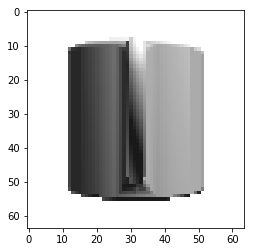

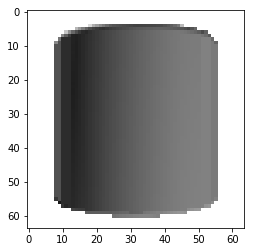

In [10]:

tmp = train_labels[18][...,::-1]
tmp1 = data_train[18][...,::-1]

print(pose[18][0][0])
plt.imshow(tmp1/255)
plt.show()
plt.imshow(tmp/255)
plt.show()


In [11]:
#normalize data


data_train *= 2
data_train /= 255
data_train -= 1

data_test *= 2
data_test /= 255
data_test -= 1


train_labels *= 2
train_labels /= 255
train_labels -= 1

test_labels *= 2
test_labels /= 255
test_labels -= 1



In [12]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [13]:
#defination of my layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    

    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)

In [14]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

inputs_ = tf.placeholder(tf.float32, (36, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (36, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (36, 8, 8, 36), name="pose")

In [15]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Max pool + Conv + relu  + Max pool + Conv + relu  + Max pool
# After 3 Convolution ,we will have a latent space

with tf.variable_scope('conv1'):
    conv1 = conv2d(inputs_, 3, 2, 16)
    tanh1 = tf.nn.relu(conv1)
    #pool1 = max_pool(tanh1, 3, 2)

# Size of pool1 would be 32*32*32

with tf.variable_scope('conv2'):
    conv2 = conv2d(tanh1, 3, 2, 32)
    tanh2 = tf.nn.relu(conv2)
    #pool2 = max_pool(tanh2, 3, 2)

# # Size of pool2 would be 16*16*16

with tf.variable_scope('conv3'):
    conv3 = conv2d(tanh2, 3, 2, 92)
    tanh3 = tf.nn.relu(conv3)
    #pool3 = max_pool(tanh3, 3, 2)

with tf.variable_scope('concat'):
    concat = tf.concat([tanh3, pose_], 3)
# # Latent space is 8*8*8
# print pool3.get_shape().as_list()
# #Building the decoder

with tf.variable_scope('deconv1'):
    deconv1 = deconv2d(concat, 3, 2, 32)
    tanh4 = tf.nn.relu(deconv1)

#print tanh4.get_shape().as_list()
with tf.variable_scope('deconv2'):
    deconv2 = deconv2d(tanh4, 3, 2, 16)
    tanh5 = tf.nn.relu(deconv2)
#print tanh5.get_shape().as_list()

with tf.variable_scope('deconv3'):
    deconv3 = deconv2d(tanh5, 3, 2, 3)
    tanh6 = tf.nn.tanh(deconv3)



In [16]:

#calculate loss
loss_op = tf.reduce_mean(abs(tanh6 - targets_))

#Optimizer
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)



In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training Parameters

epochs = 100
batch_size = 36
total_images = 6120

display_step = 1000
examples_to_show = 10


for e in range(epochs):
    for ii in range(total_images // batch_size):
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_:pose_labels}

        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=feed_dict)
    print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(loss))


Epoch: 1/100... Training loss: 0.3380
Epoch: 2/100... Training loss: 0.3251
Epoch: 3/100... Training loss: 0.3189
Epoch: 4/100... Training loss: 0.3144
Epoch: 5/100... Training loss: 0.3089
Epoch: 6/100... Training loss: 0.2970
Epoch: 7/100... Training loss: 0.2747
Epoch: 8/100... Training loss: 0.2607
Epoch: 9/100... Training loss: 0.2322
Epoch: 10/100... Training loss: 0.2243
Epoch: 11/100... Training loss: 0.2190
Epoch: 12/100... Training loss: 0.2151
Epoch: 13/100... Training loss: 0.2138
Epoch: 14/100... Training loss: 0.2115
Epoch: 15/100... Training loss: 0.2108
Epoch: 16/100... Training loss: 0.2079
Epoch: 17/100... Training loss: 0.2072
Epoch: 18/100... Training loss: 0.2057
Epoch: 19/100... Training loss: 0.2047
Epoch: 20/100... Training loss: 0.2026
Epoch: 21/100... Training loss: 0.2015
Epoch: 22/100... Training loss: 0.2001
Epoch: 23/100... Training loss: 0.1996
Epoch: 24/100... Training loss: 0.1987
Epoch: 25/100... Training loss: 0.1972
Epoch: 26/100... Training loss: 0.

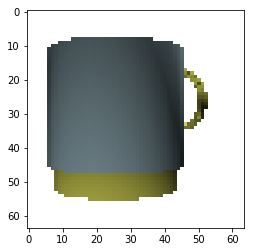

In [18]:

#compare test image 

tmp = imageset[6120+4][...,::-1]
#print tmp.shape
plt.imshow(tmp/255)
plt.show()


In [19]:


feed_dict = {inputs_: data_test[100:136], targets_: test_labels[100:136], pose_:pose[6120+100:6120+136]}

fetches = [tanh6, loss_op]
out, loss = sess.run(fetches, feed_dict=feed_dict)
#print loss

In [20]:
other = np.array(test_labels)

print(other.shape)

(1584, 64, 64, 3)


In [21]:
# test_labels_copy = test_labels[0:72]

# test_labels_copy *= max_labels
# test_labels_copy += mean_labels

# tmp = test_labels_copy[36]

# tmp = np.where(tmp>255,255,tmp)
# tmp = np.where(tmp<0,0,tmp)
# tmp = tmp
# plt.imshow(tmp)
# plt.show()

In [22]:

out += 1
out *=  255
out /= 2

# print np.amax(out)
# print np.amin(out)
# out = np.where(out>255,255,out)
# out = np.where(out<0,0,out)



(64, 64, 3)


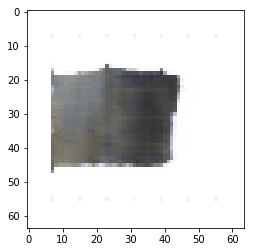

In [23]:

tmp = out[23]
print(tmp.shape)
plt.imshow(tmp/255)
plt.show()

In [24]:
other += 1
other *=  255
other /= 2

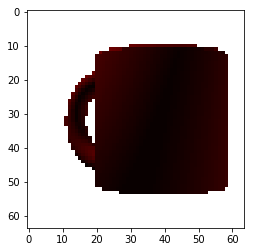

In [25]:
tmp = other[135]
plt.imshow(tmp/255)
plt.show()